In [1]:
from p_drought_indices.functions.function_clns import load_config, cut_file, subsetting_pipeline
from p_drought_indices.functions.ndvi_functions import downsample, clean_ndvi, compute_ndvi
from p_drought_indices.vegetation.cloudmask_cleaning import extract_apply_cloudmask, plot_cloud_correction, compute_difference, compute_correlation
import xarray as xr 
import pandas as pd
import yaml
from datetime import datetime, timedelta
import shutil
from shapely.geometry import Polygon, mapping
import geopandas as gpd
import matplotlib.pyplot as plt
from glob import glob
import os
#import datetime as datetime
import time
import numpy as np
import re
from p_drought_indices.vegetation.NDVI_indices import compute_svi, compute_vci
from p_drought_indices.analysis.metrics_table import MetricTable

CONFIG_PATH = r"../config.yaml"


In [2]:
path = r'D:\shareVM\MSG\AVHRR\processed\*.nc'
chunks = {"lat": -1, "lon": -1, "time": 12}

data = xr.open_mfdataset(path, chunks=chunks)
data = data.rename({'longitude':'lon', 'latitude':'lat'})

ndvi_dir = r'D:\shareVM\MSG\msg_data\batch_2\processed'
list_files = [os.path.join(ndvi_dir,file) for file in os.listdir(ndvi_dir) if re.match('HRSEVIRI_201\d+.*', file)]
xr_df = xr.open_mfdataset(list_files, chunks=chunks)

CONFIG_PATH = r"../config.yaml"

config = load_config(CONFIG_PATH)
shapefile_path = config['SHAPE']['africa']
gdf = gpd.read_file(shapefile_path)

countries = ['Ethiopia','Kenya','Somalia']

subset = gdf[gdf.ADM0_NAME.isin(countries)]
ds_avh = cut_file(data, subset)

base_dir = r'D:\shareVM\MSG\cloudmask\processed_clouds\batch_2\nc_files\new\ndvi_mask.nc'
chunks = {"lat": -1, "lon": -1, "time": 12}
cl_df = xr.open_mfdataset(base_dir, chunks=chunks)
cl_df = cl_df.sel(time=slice(cl_df['time'].min(), '2009-12-31'))

ds = cut_file(xr_df, subset)
ds_cl = cut_file(cl_df, subset)
mask_clouds_p, res_xr_p,  mask_clouds, res_xr = extract_apply_cloudmask(ds, ds_cl)

In [14]:
from fusets import WhittakerTransformer
result = WhittakerTransformer().fit_transform(mask_clouds['ndvi'].load(),smoothing_lambda=1,time_dimension="time", prediction_period="P1D")

In [16]:
from fusets._xarray_utils import _extract_dates, _output_dates, _topydate

dates = _extract_dates(xr_df['ndvi'])
expected_dates = _output_dates('P1D',dates[0],dates[-1])

xr_df['time'] = xr_df.indexes['time'].normalize()
xr_df = xr_df.assign_coords(time = xr_df.indexes['time'].normalize())

result['time'] = [np.datetime64(i) for i in expected_dates]

In [23]:
result.to_netcdf(r'D:\shareVM\MSG\msg_data\processed\smoothed_ndvi.nc')
veg_df = xr.open_dataset(r'D:\shareVM\MSG\msg_data\processed\smoothed_ndvi.nc')

In [ ]:
for date in pd.date_range(start='2005-04-16',end='2005-10-14', freq='1D'):
    date_new = date.strftime("%Y-%m-%d")
    ds_avh.sel(time=date_new, method='nearest')['NDVI'].plot()
    plt.show()
    print('NDVI for AVHRR for day {}'.format(date))
    cl_df.sel(time=date_new)['cloud_mask'].plot()
    plt.show()
    print('Showing cloud mask for day {}'.format(date))
    mask_clouds['ndvi'].sel(time=date_new, method='nearest').plot()
    plt.show()
    print('NDVI for SEVIRI for day {}'.format(date))

In [25]:
vci = compute_vci(veg_df['ndvi'])
#res = compute_svi(res_xr)
vci.to_netcdf(r'D:\shareVM\MSG\msg_data\processed\vci_1D.nc')
#res.to_netcdf(r'D:\shareVM\MSG\msg_data\processed\svi_1D.nc')

 c:\users\riccardo\desktop\phd_docs\drought_prediction\project\indices_analysis\p_drought_indices\vegetation\NDVI_indices.py:59: RuntimeWarning:invalid value encountered in true_divide


### Correlating SPI and VCI

In [ ]:

CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)
product_directory =  r"D:\shareVM\MSG\msg_data\processed"
product_dir = config['SPI']['ERA5']['path']
var = 'vci'
var_target = 'spi_gamma_180'

spi = MetricTable(product_directory, product_dir, var, var_target, CONFIG_PATH)

In [6]:
CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)

final_df = pd.DataFrame()
product_directories = [config['SPI']['CHIRPS']['path'], config['SPI']['IMERG']['path'], config['SPI']['ERA5']['path'],
                            config['SPI']['GPCC']['path']]
var = 'vci'
product_directory = r"D:\shareVM\MSG\msg_data\processed"

countries = ['Ethiopia','Kenya','Somalia']

for country in countries:
    for product_dir in product_directories:
        for latency in [30, 60, 90, 180]:
            var_target = 'spi_gamma_{}'.format(latency)
            ds = MetricTable(product_directory, product_dir, var, var_target, CONFIG_PATH, vci_tresh = 35, spi_tresh=-1, countries=[country])
            ds.table_res['country'] = country
            final_df = pd.concat([final_df, ds.table_res], ignore_index=True)

### Plotting NDVI series

In [41]:
veg_df = xr.open_dataset(r'D:\shareVM\MSG\msg_data\processed\smoothed_ndvi.nc')

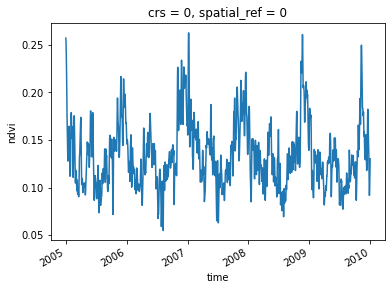

In [11]:
veg_df['ndvi'].mean(['lat','lon']).plot()

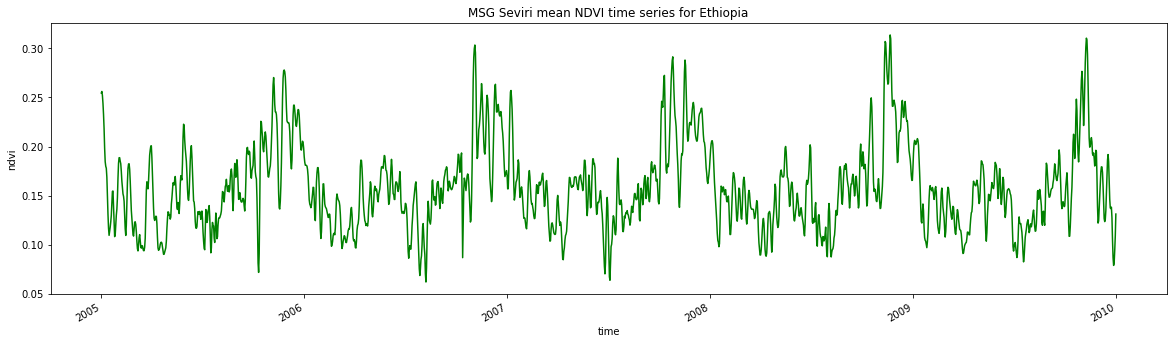

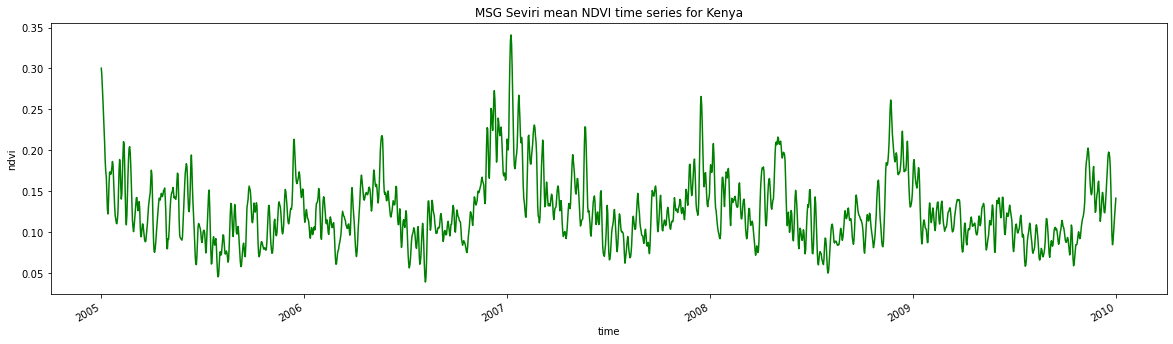

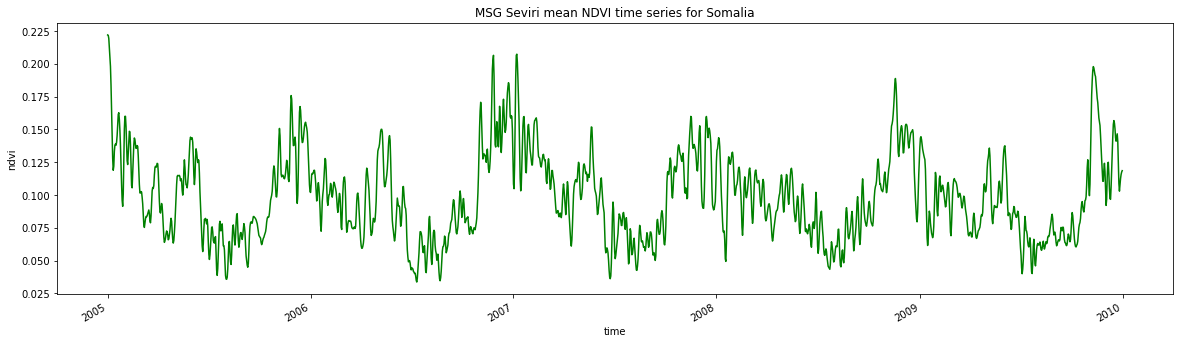

In [19]:
from p_drought_indices.functions.function_clns import subsetting_pipeline
for country in countries:
    res_df = subsetting_pipeline(CONFIG_PATH, veg_df, countries = [country], invert=False)
    plt.figure(figsize=(20,5))
    res_df['ndvi'].mean(['lat','lon']).plot(color='green')
    plt.title('MSG Seviri mean NDVI time series for {}'.format(country))
    plt.show()

In [5]:
final_df.to_csv(r'C:\Users\Riccardo\Desktop\PhD_docs\Drought_prediction\Project\Indices_analysis\notebooks\metrics_spi_vci.csv')